In [1]:
import os
import time
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.backends.cudnn as cudnn

from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


import SSFTTnet
from CNNUtils import train, test, valid
from Utils import output_metric, plot_confusion_matrix
from Utils import list_to_colormap, classification_map, print_args


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("SSFTTnet")
parser.add_argument('--dataset', choices=['HU2013', 'HanChuan', 'Salinas', 'KSC'], default='Salinas', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=10, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'HU2013':
    data = sio.loadmat(os.path.join(data_path, 'Houston.mat'))['Houston']
    label = sio.loadmat(os.path.join(data_path, 'Houston_gt.mat'))['Houston_gt']
elif args.dataset == 'HanChuan':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
    label = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
elif args.dataset == 'Salinas':
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    label = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
else:
    raise ValueError("Unknown dataset")

num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 16


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=217, band=30


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [526, 231, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (160, 15, 15, 30), type = float64
x_test  shape = (53969, 15, 15, 30), type = float64
x_valid  shape = (1600, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (160,), type = int64
y_test: shape = (53969,), type = int64
y_valid: shape = (1600,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[268,  24],
       [245,  47],
       [242,  56],
       [263,  38],
       [243,  49],
       [246,  49],
       [257,  21],
       [243,  45],
       [247,  36],
       [245,  51]])

In [10]:
# load data
x_train = torch.from_numpy(x_train).unsqueeze(1).type(torch.FloatTensor)  # (90, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test).unsqueeze(1).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid).unsqueeze(1).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=32, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([160, 1, 15, 15, 30])
torch.Size([53969, 1, 15, 15, 30])
torch.Size([1600, 1, 15, 15, 30])


# Model

In [11]:
model = SSFTTnet.SSFTTnet(num_classes=num_classes).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-06)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [12]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)

In [13]:
model_summary(model)

token_wA: 1x4x64 = 256
token_wV: 1x64x64 = 4096
pos_embedding: 1x5x64 = 320
cls_token: 1x1x64 = 64
conv3d_features.0.weight: 8x1x3x3x3 = 216
conv3d_features.0.bias: 8
conv3d_features.1.weight: 8
conv3d_features.1.bias: 8
conv2d_features.0.weight: 64x224x3x3 = 129024
conv2d_features.0.bias: 64
conv2d_features.1.weight: 64
conv2d_features.1.bias: 64
transformer.layers.0.0.fn.norm.weight: 64
transformer.layers.0.0.fn.norm.bias: 64
transformer.layers.0.0.fn.fn.to_qkv.weight: 192x64 = 12288
transformer.layers.0.0.fn.fn.to_qkv.bias: 192
transformer.layers.0.0.fn.fn.nn1.weight: 64x64 = 4096
transformer.layers.0.0.fn.fn.nn1.bias: 64
transformer.layers.0.1.fn.norm.weight: 64
transformer.layers.0.1.fn.norm.bias: 64
transformer.layers.0.1.fn.fn.net.0.weight: 8x64 = 512
transformer.layers.0.1.fn.fn.net.0.bias: 8
transformer.layers.0.1.fn.fn.net.3.weight: 64x8 = 512
transformer.layers.0.1.fn.fn.net.3.bias: 64
nn1.weight: 16x64 = 1024
nn1.bias: 16

Total Trainable Parameters: 153224


In [14]:
print('start training')
acc_list = [0.00]
path = './model/SSFTTnet.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to SSFTTnet.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 2.3872 - train_acc: 34.3750 - valid_loss: 1.7863 - valid_acc: 69.5000
val_acc improved from 0.0000 to 69.5000, saving model to SSFTTnet.pt
Epoch: 002 - train_loss: 1.5049 - train_acc: 75.6250 - valid_loss: 1.1667 - valid_acc: 81.0625
val_acc improved from 69.5000 to 81.0625, saving model to SSFTTnet.pt
Epoch: 003 - train_loss: 1.0354 - train_acc: 80.6250 - valid_loss: 0.7766 - valid_acc: 82.7500
val_acc improved from 81.0625 to 82.7500, saving model to SSFTTnet.pt
Epoch: 004 - train_loss: 0.7033 - train_acc: 85.6250 - valid_loss: 0.4893 - valid_acc: 91.5625
val_acc improved from 82.7500 to 91.5625, saving model to SSFTTnet.pt
Epoch: 005 - train_loss: 0.4853 - train_acc: 92.5000 - valid_loss: 0.3188 - valid_acc: 95.3125
val_acc improved from 91.5625 to 95.3125, saving model to SSFTTnet.pt
Epoch: 006 - train_loss: 0.3351 - train_acc: 95.0000 - valid_loss: 0.2246 - valid_acc: 96.7500
val_acc improved from 95.3125 to 96.7500, saving model to SSFTTnet

In [15]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [16]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 95.52, AA: 98.27, Kappa: 0.9502
*******************************************************************
Recal: [ 98.8  100.   100.   100.    99.18  99.97  99.92  84.5   99.73  98.78
  99.91  99.84  99.56 100.    92.35  99.83]
*******************************************************************
Parameter:
dataset: Salinas
seed: 42
batch_size: 32
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 10
*******************************************************************


In [17]:
average_accuracy = str(list(AA_test))
file_name = "./CR/ssftt_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [18]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [19]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (54129, 15, 15, 30), type = float64
x_backward  shape = (56975, 15, 15, 30), type = float64
*******************************************************


In [20]:
# load data
x_forward = torch.from_numpy(x_forward).unsqueeze(1).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward).unsqueeze(1).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([54129, 1, 15, 15, 30])
torch.Size([56975, 1, 15, 15, 30])


In [21]:
# output classification maps
pre_forward = output_label(model, forward_loader)
pre_backward = output_label(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

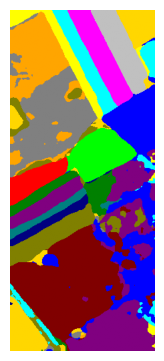

In [22]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './salinas_ssftt.pdf')